# DIY Covid-19 Dashboard - Matthew Alexander Bieda

This is an interactive dasboard created to graphically demonstrate the impact of the Covid-19 pandemic in various ways. 

In [33]:
import ipywidgets as wdg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from uk_covid19 import Cov19API
import datetime

In [34]:
# makes plots outputs appear and be stored within the notebook
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [35]:
with open("agedistribution.json", "rt") as INFILE:
    data=json.load(INFILE)

# How this dashboard was constructed

## Step 1: Query the PHE API with the SDK

The first step in this task was to obtain some data so it could be graphically represented. This was accomplished through the coronavirus.data.gov.uk public API, with the aid of a Python SDK. Once obtained data was saved in JSON format. 

In [36]:
filters = [
    'areaType=nation',
    'areaName=England'
]


# values here are the names of the PHE metrics
structure = {
    "males": "maleCases",
    "females": "femaleCases"
}

api = Cov19API(filters=filters, structure=structure)

# NOTE: this call polls the server. It may fail in case of connectivity problems or if the data
# are not available for any reason. It will also fail if the metric in the structure are not compatible
# with the filters (eg they are not defined at the national or local level).
agedistribution=api.get_json()

with open("agedistribution.json", "wt") as OUTF:
    json.dump(agedistribution, OUTF)

## Step 2: Wrangling the Data

The next step is to tidy up the data so that can be displayed as a graph. This involved sorting the data, dealing with null values and adding it to a dataframe object. 

In [37]:
def wrangle_data(data):

    datadic=data['data'][0] # data['data'] is a list

    males=datadic['males']
    females=datadic['females']
    males # females is similar 

    ageranges=[x['age'] for x in males] # each entry of males is a dictionary

    def min_age(agerange):
        agerange=agerange.replace('+','') # remove the + from 90+
        start=agerange.split('_')[0]
        return int(start)

    ageranges.sort(key=min_age)

    age_df=pd.DataFrame(index=ageranges, columns=['males','females', 'total'])

    for entry in males: # each entry is a dictionary
        ageband=entry['age'] # our index position
        age_df.loc[ageband, 'males']=entry['value']
    
    for entry in females:
        ageband=entry['age']
        age_df.loc[ageband, 'females']=entry['value']
    
    # this is straightforward
    age_df['total']=age_df['males']+age_df['females']
    
    return age_df

dataframe = wrangle_data(data)

## Simple Graphical Representation

A non-interactive graph can be constructed directly from the dataframe object we obtained after wrangling the data. 

<AxesSubplot:>

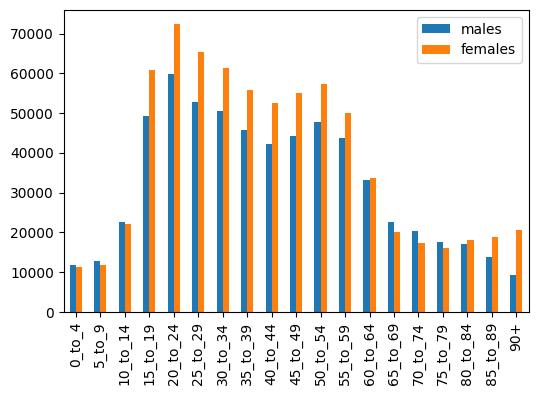

In [38]:
dataframe.plot(kind='bar', y=['males','females'])

## Interactive Graph

To make the graph more interesting, we can implement interactive elements such as a refresh button to update the data, and  give the viewer the ability to view subsets of the data independently. 

Click to select data for graph
CTRL-Click to select more than one category

In [39]:
# Place your API access code in this function. Do not call this function directly; it will be called by 
# the button callback. 
def access_api():
    """ Accesses the PHE API. Returns raw data in the same format as data loaded from the "canned" JSON file. """
    filters = [
        'areaType=nation',
        'areaName=England'
    ]
    structure = {
        "males": "maleCases",
        "females": "femaleCases"
    }
    api = Cov19API(filters=filters, structure=structure)
    agedistribution=api.get_json()

    with open("agedistribution.json", "wt") as OUTF:
        json.dump(agedistribution, OUTF)
        
    with open("agedistribution.json", "rt") as INFILE:
        data=json.load(INFILE)
        
    return data # return data read from the API

In [45]:
# our API access function. This will be called by the button when it is clicked
# Printout from this function will be lost in Voila unless captured in an
# output widget - therefore, we give feedback to the user by changing the 
# appearance of the button
def api_button_callback(button):
    """ Button callback - it must take the button as its parameter (unused in this case).
    Accesses API, wrangles data, updates global variable df used for plotting. """
    # Get fresh data from the API. If you have time, include some error handling around this call.
    apidata=access_api()
    # wrangle the data and overwrite the dataframe for plotting
    global dataframe
    dataframe = wrangle_data(data)
    # the graph won't refresh until the user interacts with the widget.
    # this function simulates the interaction, see Graph and Analysis below.
    # you can omit this step in the first instance
    # after all is done, you can switch the icon on the button to a "check" sign
    # and optionally disable the button - it won't be needed again. You can use icons
    # "unlink" or "times" and change the button text to "Unavailable" in case the 
    # api call fails.
    apibutton.icon="check"
    apibutton.disabled=True
    print("Data updated at" + str(datetime.datetime.now()))
    
apibutton=wdg.Button(
    description='Update Data', # you may want to change this...
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip="Click to download updated data from PHE",
    # FontAwesome names without the `fa-` prefix - try "download"
    icon='download'
)

# remember to register your button callback function with the button
apibutton.on_click(api_button_callback) # the name of your function inside these brackets

display(apibutton)

# run all cells before clicking on this button

Button(description='Update Data', icon='download', style=ButtonStyle(), tooltip='Click to download updated dat…

Data updated at2020-11-26 17:12:06.961692


In [18]:
agecols=wdg.SelectMultiple(
    options=['males', 'females', 'total'], # options available
    value=['males', 'females'], # initial value
    rows=3, # rows of the selection box
    description='Sex',
    disabled=False
)

def age_graph(graphcolumns):
    # our callback function.
    ncols=len(graphcolumns)
    if ncols>0:
        dataframe.plot(kind='bar', y=list(graphcolumns)) # graphcolumns is a tuple - we need a list
    else:
        # if the user has not selected any column, print a message instead
        print("Click to select data for graph")
        print("(CTRL-Click to select more than one category)")
        
# keep calling age_graph(graphcolumns=value_of_agecols); capture output in variable output    
output=wdg.interactive_output(age_graph, {'graphcolumns': agecols})

display(agecols, output)

SelectMultiple(description='Sex', index=(0, 1), options=('males', 'females', 'total'), rows=3, value=('males',…

Output()